# TD DS co-op case study
### Dhiren Kakkar

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
print(train.shape)
print(test.shape)
train.tail()

(391749, 5)
(20000, 5)


,ID,USERID,EVENTID,TIMESTAMP,LABEL
391744,391744,1142,90,2497251,0
391745,391745,1142,70,2497253,0
391746,391746,2816,20,2497253,0
391747,391747,1142,73,2497254,0
391748,391748,5059,25,2497257,0


In [4]:
test.head(10)

,ID,USERID,EVENTID,TIMESTAMP,LABEL
0,391749,6751,8,2497257,NaN
1,391750,5059,26,2497260,NaN
2,391752,2816,49,2497261,NaN
3,391752,2816,49,2497261,NaN
4,391753,6751,7,2497261,NaN
5,391754,5059,28,2497262,NaN
6,391755,6669,72,2497263,NaN
7,391756,7001,80,2497264,NaN
8,391757,6669,73,2497264,NaN
9,391758,6751,8,2497264,NaN


- The test set IDs follows the last observation ID of the training set. So expanding/rolling window transformations are possible without dropping/filling any test set data.

In [5]:
train.dtypes

ID           int64
USERID       int64
EVENTID      int64
TIMESTAMP    int64
LABEL        int64
dtype: object

### Exploratory analysis

In [6]:
#unique and missing values
print('Unique users: ' + str(train['USERID'].nunique()))
print('Unique events: ' + str(train['EVENTID'].nunique()))
print('Unique timestamps: ' + str(train['TIMESTAMP'].nunique()))
print('\nMissing data:\n' + str(train.isnull().sum()))

Unique users: 7002
Unique events: 97
Unique timestamps: 330366

Missing data:
ID           0
USERID       0
EVENTID      0
TIMESTAMP    0
LABEL        0
dtype: int64


In [7]:
#label distribution
train['LABEL'].value_counts()

0    387850
1      3899
Name: LABEL, dtype: int64

Labels are highly imbalanced. Oversampling label=1 or undersampling label=0 could be good options, but they may lead to overfitting or reducing data respectively. So I'll evaluate models with their **precision/recall**.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


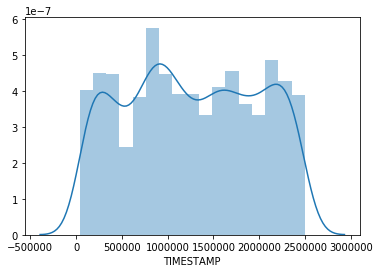

In [8]:
#distribution of timestamps at churn (label=1)
sns.distplot(train.loc[train['LABEL']==1].TIMESTAMP)

- Slight deviations from uniform distribution for timestamps of churn events (label=1)

In [9]:
print(train['TIMESTAMP'].diff().head(10))

0     NaN
1     6.0
2    35.0
3     8.0
4     2.0
5     4.0
6     4.0
7     3.0
8     3.0
9    48.0
Name: TIMESTAMP, dtype: float64


Since the **data points occur at uneven intervals** (both globally and for each user), time series modelling approaches like ARIMA would not apply well since they assume evenly spaced series. Instead, my approach would be to **embed both user and sequence data within features** to capture both global and local trends of user interaction leading to churn.

In [10]:
#frequency of an event's occurance
i = len(train) -1 
train[train['ID'] < i].groupby('EVENTID').agg({'EVENTID':'count'}).T

EVENTID,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
EVENTID,1577,12828,4705,14135,11526,11132,7695,15349,19244,14366,...,30,29,15,14,21,9,11,6,13,15


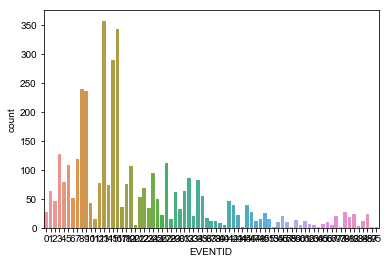

In [11]:
#frequency of each event leading to churn
sns.countplot(x='EVENTID',data=train.loc[train['LABEL']==1])
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 0.7)

In [12]:
#percentage vs raw frequency of number of times each event led to churn 
xx = train.groupby('EVENTID').agg({'LABEL':['sum','count']})
xx.columns = ['sum','count']
xx['pctLabel'] = 100*xx['sum']/xx['count']
xx.drop(['sum','count'], axis=1, inplace=True)
print(xx.sort_values('pctLabel', ascending=False)) 
print((train.loc[train['LABEL']==1].EVENTID).value_counts().head(10))

         pctLabel
EVENTID          
95       7.692308
16       4.511873
13       4.000448
15       3.738197
87       3.333333
...           ...
77       0.000000
76       0.000000
75       0.000000
74       0.000000
96       0.000000

[97 rows x 1 columns]
13    357
16    342
15    289
8     240
9     235
3     127
7     119
27    112
5     109
19    106
Name: EVENTID, dtype: int64


- EVENTID=13,15,16 have the highest frequency leading to churn. 
- They also have higher ratio of churn indicating they can be potential predictors. Same applies for the latest preceding event.

In [13]:
copy = train.copy()
copy['USER_FIRST'] = copy.groupby('USERID')['TIMESTAMP'].transform('first')
copy['USER_LAST'] = copy.groupby('USERID')['TIMESTAMP'].transform('last')
copy['TIME_OPEN'] = copy['USER_LAST'] - copy['USER_FIRST']

In [14]:
#median time since each customer's first interaction leading to each label
copy.groupby('LABEL').agg({'TIME_OPEN':'median'})

,TIME_OPEN
LABEL,
0,1658134
1,183448


- Significant difference in the median time since a given user's first interaction i.e. **users who churn tend to do it in a much shorter duration**

In [15]:
#median number of interactions leading to each label
copy['INTERACTIONS'] = copy.groupby('USERID')['ID'].transform('count')
copy.groupby('LABEL').agg({'INTERACTIONS':'median'})

,INTERACTIONS
LABEL,
0,102
1,18


Similar deductions as TIME_OPEN for median interactions i.e. **users who churn tend to interact much less**

In [16]:
#median time between interactions leading to each label (mean is significantly higher for label=1, indicating skew)
copy['DELTA'] = copy.groupby('USERID')['TIMESTAMP'].diff()
copy['MED_DELTA'] = copy.groupby('USERID')['DELTA'].transform('median')
copy.groupby('LABEL').agg({'MED_DELTA':'median'})

,MED_DELTA
LABEL,
0,20.0
1,24.0


There isn't a significant difference in the median time between interactions, however, there is a large skew in this distribution since there is much more prevelant difference in the respective means.

### Feature engineering

In [17]:
df_train = train.copy()
df_test = test.copy()
df_train['type'] = 1
df_test['type'] = 0

In [18]:
df = pd.concat([df_train, df_test])

In [19]:
df.reset_index(drop=True, inplace=True)

#### Local features (each user)

In [20]:
#TIME_OPEN - total time since the user's first interaction was recorded
df['USER_FIRST'] = df.groupby('USERID')['TIMESTAMP'].transform('first')
df['USER_LAST'] = df.groupby('USERID')['TIMESTAMP'].expanding().max().reset_index(0,drop=True)
df['TIME_OPEN'] = df['USER_LAST'] - df['USER_FIRST']

In [21]:
#removing intermediate columns for TIME_OPEN
df.drop(['USER_FIRST','USER_LAST'], axis=1, inplace=True)

In [22]:
#DELTA - time between given user's subsequent interactions
#MED_DELTA - median time between given user's subsequent interactions
df['DELTA'] = df.groupby('USERID')['TIMESTAMP'].diff()
df['MED_DELTA'] = df.groupby('USERID')['DELTA'].transform('median')

In [23]:
#INTERACTIONS - total number of interaction events leading upto current observation
df['INTERACTIONS'] = df.groupby('USERID')['ID'].expanding().count().reset_index(0,drop=True)

In [24]:
#PREV_EVENT - user's previous interaction event id
df['PREV_EVENT'] = df.groupby('USERID')['EVENTID'].shift()

#### Global features (general trends)

In [25]:
#Global features to describe TIME_OPEN's distrbution (not taking mean to avoid multicollinearity with median/std)
df['MED_TIME_OPEN'] = df['TIME_OPEN'].expanding().median()
df['KURT_TIME_OPEN'] = df['TIME_OPEN'].expanding().kurt()
df['SKEW_TIME_OPEN'] = df['TIME_OPEN'].expanding().skew()
df['STD_TIME_OPEN'] = df['TIME_OPEN'].expanding().std()

In [26]:
#Global features to describe MED_DELTA's distrbution (not taking mean to avoid multicollinearity with median/std)
df['MED_MED_DELTA'] = df['MED_DELTA'].expanding().median()
df['KURT_MED_DELTA'] = df['MED_DELTA'].expanding().kurt()
df['SKEW_MED_DELTA'] = df['MED_DELTA'].expanding().skew()
df['STD_MED_DELTA'] = df['MED_DELTA'].expanding().std()

In [27]:
#filling missing values: most values missing are due to lack to preceding rows for expanding window calculation. 
#Hence fill 0 for all missing data and -1 for missing EVENTID 
df['DELTA'] = df['DELTA'].fillna(0)
df['KURT_MED_DELTA'] = df['KURT_MED_DELTA'].fillna(0)
df['SKEW_MED_DELTA'] = df['SKEW_MED_DELTA'].fillna(0)
df['KURT_TIME_OPEN'] = df['KURT_MED_DELTA'].fillna(0)
df['SKEW_TIME_OPEN'] = df['SKEW_MED_DELTA'].fillna(0)
df['STD_MED_DELTA'] = df['STD_MED_DELTA'].fillna(0)
df['STD_TIME_OPEN'] = df['STD_TIME_OPEN'].fillna(0)
df['PREV_EVENT'] = df['PREV_EVENT'].fillna(-1) #category

In [28]:
df.isna().sum()

ID                    0
USERID                0
EVENTID               0
TIMESTAMP             0
LABEL             20000
type                  0
TIME_OPEN             0
DELTA                 0
MED_DELTA             0
INTERACTIONS          0
PREV_EVENT            0
MED_TIME_OPEN         0
KURT_TIME_OPEN        0
SKEW_TIME_OPEN        0
STD_TIME_OPEN         0
MED_MED_DELTA         0
KURT_MED_DELTA        0
SKEW_MED_DELTA        0
STD_MED_DELTA         0
dtype: int64

In [29]:
df.drop(['ID','USERID','TIMESTAMP'], axis=1, inplace=True)

In [30]:
#converting EVENTID to str to treat as a category
df['EVENTID'] = df['EVENTID'].astype('str')
df['PREV_EVENT'] = df['PREV_EVENT'].astype('str')

In [31]:
#dummy encoding
df = pd.get_dummies(df)

In [32]:
df.shape

(411749, 209)

In [33]:
train_df = df[df['type']==1]
test_df = df[df['type']==0]
train_df.drop(['type'], axis=1, inplace=True)
test_df.drop(['type'], axis=1, inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [34]:
train_df.shape

(391749, 208)

In [35]:
test_df.shape

(20000, 208)

### Validation setup

For validation, we can't split the data randomly because of the sequential nature of data. Rather, I carried out validation by splitting the training set into two parts where the validation set follows sequentially after the training set. A better validation approach will be to use time series cross validation using rolling/expanding windows.

In [36]:
#90% data training set
trainidx = int(0.9*train_df.shape[0])

In [37]:
xtrain,ytrain = train_df.drop('LABEL', axis=1).iloc[:trainidx].copy(), train_df['LABEL'].iloc[:trainidx].copy()
xval,yval = train_df.drop('LABEL', axis=1).iloc[trainidx:].copy(), train_df['LABEL'].iloc[trainidx:].copy()

### Model development

In [38]:
#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report

In [39]:
clf = RidgeClassifier(random_state=0, class_weight='balanced').fit(xtrain, ytrain)
#clf = LogisticRegression(random_state=0, class_weight='balanced').fit(xtrain, ytrain)
#clf_rf = RandomForestClassifier(max_depth=None, random_state=0, class_weight='balanced').fit(xtrain, ytrain)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.901704e-18
  overwrite_a=True).T


* "class_weight='balanced'" indicated that the labels are imbalanced and the model uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data.

In [40]:
clf.score(xtrain,ytrain)

0.689662312025277

In [41]:
clf.score(xval,yval)

0.7558391831525207

### Model evaluation

General classifier score is 75.5% accuracy on the validation set. However, the data is imbalanced and so its important to identify how the model performs in terms of precision/recall of the respective labels.

In [42]:
feats = pd.DataFrame()
feats['column'] = xtrain.columns
feats['coef'] = clf.coef_[0]

In [43]:
feats.sort_values('coef',ascending=False)

,column,coef
20,EVENTID_16,0.680220
40,EVENTID_34,0.621042
78,EVENTID_69,0.613749
92,EVENTID_81,0.591094
41,EVENTID_35,0.559243
...,...,...
88,EVENTID_78,-0.457011
175,PREV_EVENT_68.0,-0.508791
85,EVENTID_75,-0.563459
61,EVENTID_53,-0.640978


In [44]:
# ridge clf model report
print(classification_report(yval, clf.predict(xval)))

              precision    recall  f1-score   support

         0.0       1.00      0.76      0.86     38793
         1.0       0.03      0.68      0.05       382

   micro avg       0.76      0.76      0.76     39175
   macro avg       0.51      0.72      0.46     39175
weighted avg       0.99      0.76      0.85     39175



A recall of 0.68 inclidates that 68% of the churn events were classified correctly. This is a significant improvement over the naive implementation which predicts 0 for all users (thus giving 99% overall accuracy but 0 recall on labl=1)

In [45]:
# naive method report - predict all outcomes as 0
print(classification_report(yval, np.zeros(39175)))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     38793
         1.0       0.00      0.00      0.00       382

   micro avg       0.99      0.99      0.99     39175
   macro avg       0.50      0.50      0.50     39175
weighted avg       0.98      0.99      0.99     39175



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Thus with a micro-avg F1 score of 0.75 (weighted for balance), ridge classifier performs significantly better than the naive approach to identify churn events. However, it has low precision and thus further model complexity can restrict positive predictions to higher contraints.

I wanted to also try random forest classifier with grid search in order to optimize the rf model and reduce the heavy overfitting occuring with default hyperparams. However, my local device takes too long to compute the best set of params.

In [46]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

# param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 10, 12, 16], "n_estimators": [50, 100, 400, 700, 1000]} 
# gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring= "precision", cv=3, n_jobs=-1) 
# gs = gs.fit(xval, yval)

### Prediction

In [47]:
pred = clf.predict(test_df.drop(['LABEL'],axis=1))

In [48]:
test['LABEL'] = pred

In [49]:
test.to_csv('final_submission', index=False)